# Step 4: Baseline Model Development

**Objective:** Train a Linear Regression baseline, evaluate its performance,
and establish metrics to beat in Phase 5.

---

## 4.1 Setup

In [1]:
import sys
sys.path.insert(0, "..")

import pandas as pd
import numpy as np

from src.models import train_model, save_model
from src.evaluation import evaluate_model, print_metrics
from src.visualization import plot_actual_vs_predicted, plot_residuals

# Load preprocessed splits
X_train = pd.read_csv("../data/processed/X_train.csv")
X_test  = pd.read_csv("../data/processed/X_test.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").squeeze()
y_test  = pd.read_csv("../data/processed/y_test.csv").squeeze()

print(f"Training samples: {len(X_train):,}")
print(f"Test samples:     {len(X_test):,}")
print(f"Features:         {X_train.shape[1]}")

Training samples: 45,600
Test samples:     11,400
Features:         76


## 4.2 Train Linear Regression Baseline

In [2]:
lr_model = train_model("linear_regression", X_train, y_train)

Trained: linear_regression (LinearRegression)


## 4.3 Evaluate on Test Set

In [ ]:
lr_metrics = evaluate_model(lr_model, X_test, y_test)
print("\n=== Linear Regression Baseline (log-scale) ===")
print_metrics(lr_metrics)

# BDT-scale metrics (inverse log1p transform)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_bdt     = np.expm1(y_test)
preds_bdt = np.maximum(np.expm1(lr_metrics["predictions"]), 0)
bdt_r2    = r2_score(y_bdt, preds_bdt)
bdt_mae   = mean_absolute_error(y_bdt, preds_bdt)
bdt_rmse  = np.sqrt(mean_squared_error(y_bdt, preds_bdt))

print(f"\n=== Linear Regression Baseline (BDT-scale) ===")
print(f"  R²   = {bdt_r2:.4f}")
print(f"  MAE  = {bdt_mae:,.0f} BDT")
print(f"  RMSE = {bdt_rmse:,.0f} BDT")

## 4.4 Actual vs Predicted

Saved → reports/figures/actual_vs_predicted.png


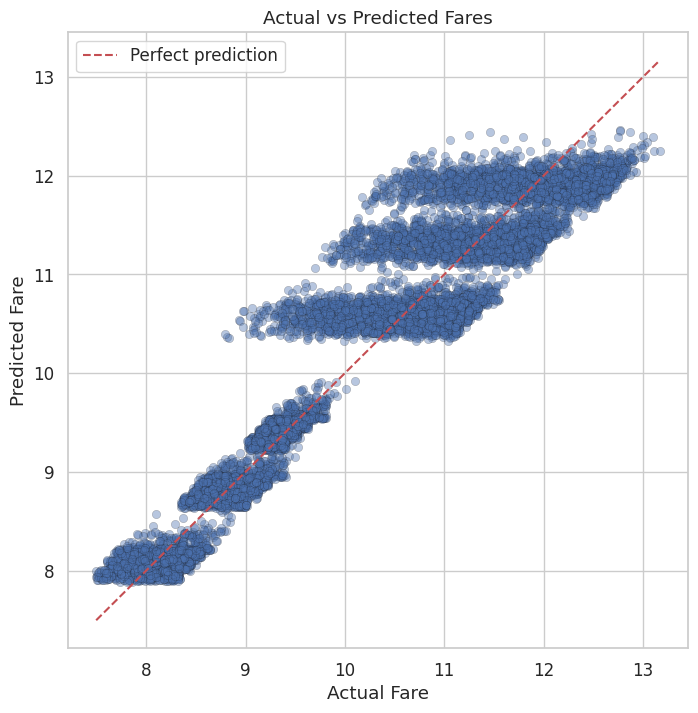

<Axes: title={'center': 'Actual vs Predicted Fares'}, xlabel='Actual Fare', ylabel='Predicted Fare'>

In [4]:
plot_actual_vs_predicted(y_test, lr_metrics["predictions"])

## 4.5 Residual Analysis

Saved → reports/figures/residuals.png


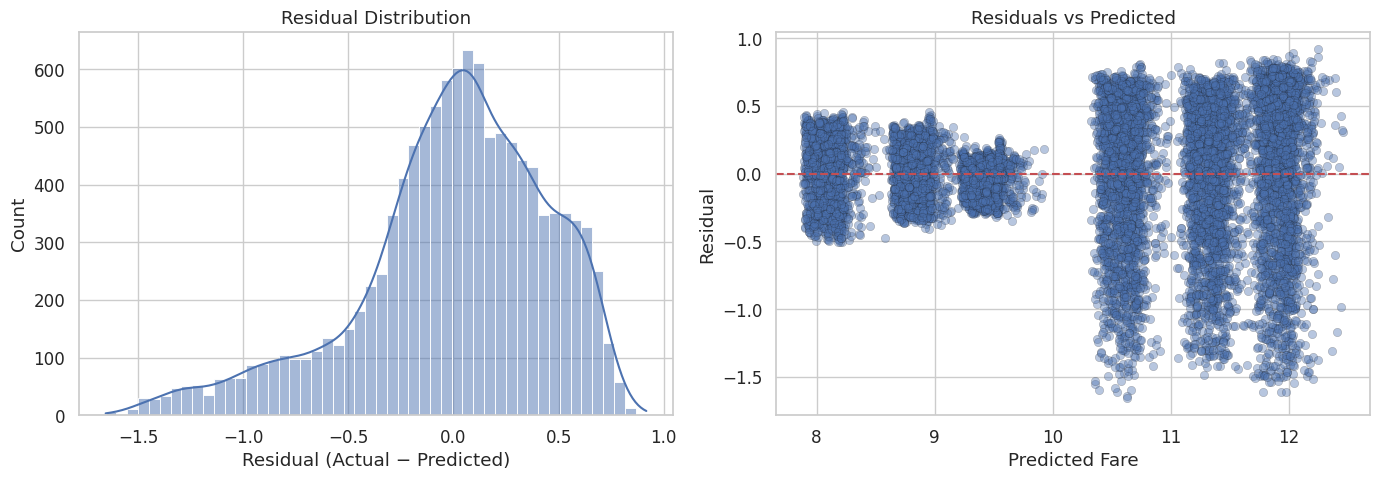

array([<Axes: title={'center': 'Residual Distribution'}, xlabel='Residual (Actual − Predicted)', ylabel='Count'>,
       <Axes: title={'center': 'Residuals vs Predicted'}, xlabel='Predicted Fare', ylabel='Residual'>],
      dtype=object)

In [5]:
plot_residuals(y_test, lr_metrics["predictions"])

## 4.6 Save Baseline Model

In [6]:
save_model(lr_model, "../models/linear_regression_baseline.joblib")

Model saved → ../models/linear_regression_baseline.joblib


## 4.7 Baseline Metrics & Improvement Target

| Metric | Log-scale | BDT-scale |
|--------|-----------|-----------|
| R²     | 0.8935    | 0.6506    |
| MAE    | 0.3523    | 28,525 BDT |
| RMSE   | 0.4587    | 48,260 BDT |

**Note on scales:**
- **Log-scale:** Computed on the `log1p`-transformed target — used for model comparison and selection.
- **BDT-scale:** Inverse-transformed back to actual Bangladeshi Taka — meaningful for business stakeholders. An average error of ~28,525 BDT across routes ranging from ~4,000 to ~117,000 BDT reflects real-world prediction precision.

**Target for Phase 5:** Compare multiple model families (including Gradient Boosting) and evaluate whether tree-based models can improve on this strong linear baseline.

**Observations:**
- After removing leakage columns and applying log-transform, the baseline Linear Regression achieves R² = 0.8935 in log space — explaining ~89% of log-fare variance using only genuine predictors (airline, route, season, etc.).
- The log-scale R² = 0.89 vs BDT-scale R² = 0.65 gap is expected: log-transform compresses the fare range, making linear prediction easier; BDT-scale R² reflects true variance explained in raw fare units.
- The R² = 0.89 reflects genuine predictive power from airline, route, class, and seasonal features — not data leakage.

> **Note:** `Base Fare` and `Tax & Surcharge` were removed from features to prevent data leakage, and `log1p` was applied to the target for skew reduction.

---

## Phase 4 Summary

The Linear Regression baseline achieved an R² of **0.8935** (log-scale) with:
- **MAE:** 0.3523 (log) / **28,525 BDT**
- **RMSE:** 0.4587 (log) / **48,260 BDT**

After removing data leakage columns (`Base Fare`, `Tax & Surcharge`) and applying a `log1p` transform to the target, the model explains ~89% of log-fare variance using genuine predictors.

**Key takeaways:**
- The strong R² = 0.89 shows that airline, route, class, and seasonal features carry substantial predictive signal even without fare component columns.
- BDT-scale MAE of ~28,525 BDT contextualises the error: on routes averaging 4,000–117,000 BDT, this represents real but improvable precision.
- Phase 5 will test whether tree-based models (Random Forest, Gradient Boosting) can improve on this baseline via non-linear feature interactions.
- The log-transform was so effective at linearising the fare distribution that Linear Regression may remain competitive with ensemble methods — a finding validated in Phase 5.